This code produces month-to-month statistics of the interannual variability of ITCZ states in the observations, reanalyses, and CMIP6 models. For plots that group the CMIP6 models together, see the code called "Interann_ITCZ_state_variability_CMIP6_groups.ipynb"

In [1]:
#Author: Alex Gonzalez
#Date: Nove"mber 2025
#Paper: JGR-Atmospheres

Figure 6. The same as Figure 4a–e but for interannual ITCZ state standard deviation. Observations include IMERG combined microwave and IR (MW+IR, solid black curves), IMERGmicrowave only (MW, dotted black curves), and GPCP (dashed black curves).

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
#import netCDF4
from scipy import stats

from cartopy import config

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker

from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
region = 'EastPac'
region_str = 'East Pacific Ocean'
rain_thresh_str = '5.0mm'

In [4]:
datasetr = ['IMERG','IMERG_mw','GPCP','ERA5','MERRA-2','JRA-3Q','CFSR']
folders_r = ['IMERG_1deg','IMERG_1deg','GPCP_daily','ERA5_1deg','MERRA-2','JRA-3Q','CFSR']
ndatasetr = len(folders_r)

In [5]:
itcz_state_name = ['dITCZ','nITCZ','sITCZ','aITCZ','eITCZ']
nitst = len(itcz_state_name)

In [6]:
nmon = 12
month = np.arange(1,nmon+1,1)

month_xr = xr.DataArray(month, coords=[month], dims=['month'])
mon_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [7]:
yr0 = 1998
yrf = 2024
yr_str = str(yr0)+'-'+str(yrf)

figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
figname = 'Interann_ITCZ_state_EastPac_reana_monthly.pdf'

In [8]:
data_nI_interann_r = np.zeros((ndatasetr,nmon))
data_sI_interann_r = np.zeros((ndatasetr,nmon))
data_aI_interann_r = np.zeros((ndatasetr,nmon))
data_dI_interann_r = np.zeros((ndatasetr,nmon))
data_eI_interann_r = np.zeros((ndatasetr,nmon))

data_nI_mean_r = np.zeros((ndatasetr,nmon))
data_sI_mean_r = np.zeros((ndatasetr,nmon))
data_aI_mean_r = np.zeros((ndatasetr,nmon))
data_dI_mean_r = np.zeros((ndatasetr,nmon))
data_eI_mean_r = np.zeros((ndatasetr,nmon))
for jj in range(0,ndatasetr,1):
    dri = '/srv/lss/'+folders_r[jj]+'/total_precip/'
    fni = datasetr[jj]+'_ITCZ_st_daily_'+region+'_abs_thresh_'+rain_thresh_str

    fno = fni+'_frq_mon'

    # load ITCZ states
    data = xr.open_dataset(dri+fni+'.nc', engine='netcdf4')
    itcz_state = data['itcz_state']
    cond_dITCZ = (itcz_state == 1)
    cond_nITCZ = (itcz_state == 2)
    cond_sITCZ = (itcz_state == 3)
    cond_aITCZ = (itcz_state == 4)
    cond_eITCZ = (itcz_state == 5)

    # create daily frequencies (zeros and ones)
    frq_dITCZ = xr.where(cond_dITCZ, 1, 0)
    frq_nITCZ = xr.where(cond_nITCZ, 1, 0)
    frq_sITCZ = xr.where(cond_sITCZ, 1, 0)
    frq_aITCZ = xr.where(cond_aITCZ, 1, 0)
    frq_eITCZ = xr.where(cond_eITCZ, 1, 0)

    # name netcdf arrays
    for ff in range(0,nitst):
        if itcz_state_name[ff] == 'dITCZ':
            frq_dITCZ.name = itcz_state_name[ff]
        elif itcz_state_name[ff] == 'nITCZ':
            frq_nITCZ.name = itcz_state_name[ff]
        elif itcz_state_name[ff] == 'sITCZ':
            frq_sITCZ.name = itcz_state_name[ff]
        elif itcz_state_name[ff] == 'aITCZ':
            frq_aITCZ.name = itcz_state_name[ff]
        elif itcz_state_name[ff] == 'eITCZ':
            frq_eITCZ.name = itcz_state_name[ff]

    # prepare daily frequency data for saving to netcdf file
    dataset_daily = xr.merge([frq_nITCZ,frq_sITCZ,frq_aITCZ,frq_dITCZ,frq_eITCZ])
    dataset_daily.attrs['long_name'] = datasetr[jj]+' daily ITCZ state frequency'
    dataset_daily.attrs['method'] = 'Algorithm developed for daily averaged precipitation rate'
    dataset_daily.attrs['region'] = region

    # do not save daily files
    #dataset_daily.to_netcdf(path=dri+fno+'.nc')

    # compute monthly means of daily ITCZ state frequencies
    frq_dITCZ_mon = frq_dITCZ.resample(time='MS').mean()
    frq_nITCZ_mon = frq_nITCZ.resample(time='MS').mean()
    frq_sITCZ_mon = frq_sITCZ.resample(time='MS').mean()
    frq_aITCZ_mon = frq_aITCZ.resample(time='MS').mean()
    frq_eITCZ_mon = frq_eITCZ.resample(time='MS').mean()

    # prepare monthly frequency data for saving to netcdf file
    dataset_monthly = xr.merge([frq_nITCZ_mon,frq_sITCZ_mon,frq_aITCZ_mon,frq_dITCZ_mon,frq_eITCZ_mon])
    dataset_monthly.attrs['long_name'] = datasetr[jj]+' monthly ITCZ state frequency'
    dataset_monthly.attrs['method'] = 'Algorithm developed for daily averaged precipitation rate'
    dataset_monthly.attrs['region'] = region

    # save monthly files
    dataset_monthly.to_netcdf(path=dri+fno+'.nc')

    # subset for years of interest before computing standard deviation
    frq_dITCZ_mon_subset = frq_dITCZ_mon.sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))
    frq_nITCZ_mon_subset = frq_nITCZ_mon.sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))
    frq_sITCZ_mon_subset = frq_sITCZ_mon.sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))
    frq_aITCZ_mon_subset = frq_aITCZ_mon.sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))
    frq_eITCZ_mon_subset = frq_eITCZ_mon.sel(time=slice(str(yr0)+'-01',str(yrf)+'-12'))

    # compute standard deviations for a common time period
    data_nI_interann_r[jj,:] = (frq_nITCZ_mon_subset*100).groupby(frq_nITCZ_mon_subset['time.month']).std(dim='time')
    data_sI_interann_r[jj,:] = (frq_sITCZ_mon_subset*100).groupby(frq_sITCZ_mon_subset['time.month']).std(dim='time')
    data_aI_interann_r[jj,:] = (frq_aITCZ_mon_subset*100).groupby(frq_aITCZ_mon_subset['time.month']).std(dim='time')
    data_dI_interann_r[jj,:] = (frq_dITCZ_mon_subset*100).groupby(frq_dITCZ_mon_subset['time.month']).std(dim='time')
    data_eI_interann_r[jj,:] = (frq_eITCZ_mon_subset*100).groupby(frq_eITCZ_mon_subset['time.month']).std(dim='time')

    data_nI_mean_r[jj,:] = (frq_nITCZ_mon_subset*100).groupby(frq_nITCZ_mon_subset['time.month']).mean(dim='time')
    data_sI_mean_r[jj,:] = (frq_sITCZ_mon_subset*100).groupby(frq_sITCZ_mon_subset['time.month']).mean(dim='time')
    data_aI_mean_r[jj,:] = (frq_aITCZ_mon_subset*100).groupby(frq_aITCZ_mon_subset['time.month']).mean(dim='time')
    data_dI_mean_r[jj,:] = (frq_dITCZ_mon_subset*100).groupby(frq_dITCZ_mon_subset['time.month']).mean(dim='time')
    data_eI_mean_r[jj,:] = (frq_eITCZ_mon_subset*100).groupby(frq_eITCZ_mon_subset['time.month']).mean(dim='time')

In [9]:
data_nI_interannr_xr = xr.DataArray(data_nI_interann_r, coords=[datasetr,month], dims=['dataset','month'])
data_sI_interannr_xr = xr.DataArray(data_sI_interann_r, coords=[datasetr,month], dims=['dataset','month'])
data_aI_interannr_xr = xr.DataArray(data_aI_interann_r, coords=[datasetr,month], dims=['dataset','month'])
data_dI_interannr_xr = xr.DataArray(data_dI_interann_r, coords=[datasetr,month], dims=['dataset','month'])
data_eI_interannr_xr = xr.DataArray(data_eI_interann_r, coords=[datasetr,month], dims=['dataset','month'])

In [10]:
data_nI_meanr_xr = xr.DataArray(data_nI_mean_r, coords=[datasetr,month], dims=['dataset','month'])
data_sI_meanr_xr = xr.DataArray(data_sI_mean_r, coords=[datasetr,month], dims=['dataset','month'])
data_aI_meanr_xr = xr.DataArray(data_aI_mean_r, coords=[datasetr,month], dims=['dataset','month'])
data_dI_meanr_xr = xr.DataArray(data_dI_mean_r, coords=[datasetr,month], dims=['dataset','month'])
data_eI_meanr_xr = xr.DataArray(data_eI_mean_r, coords=[datasetr,month], dims=['dataset','month'])

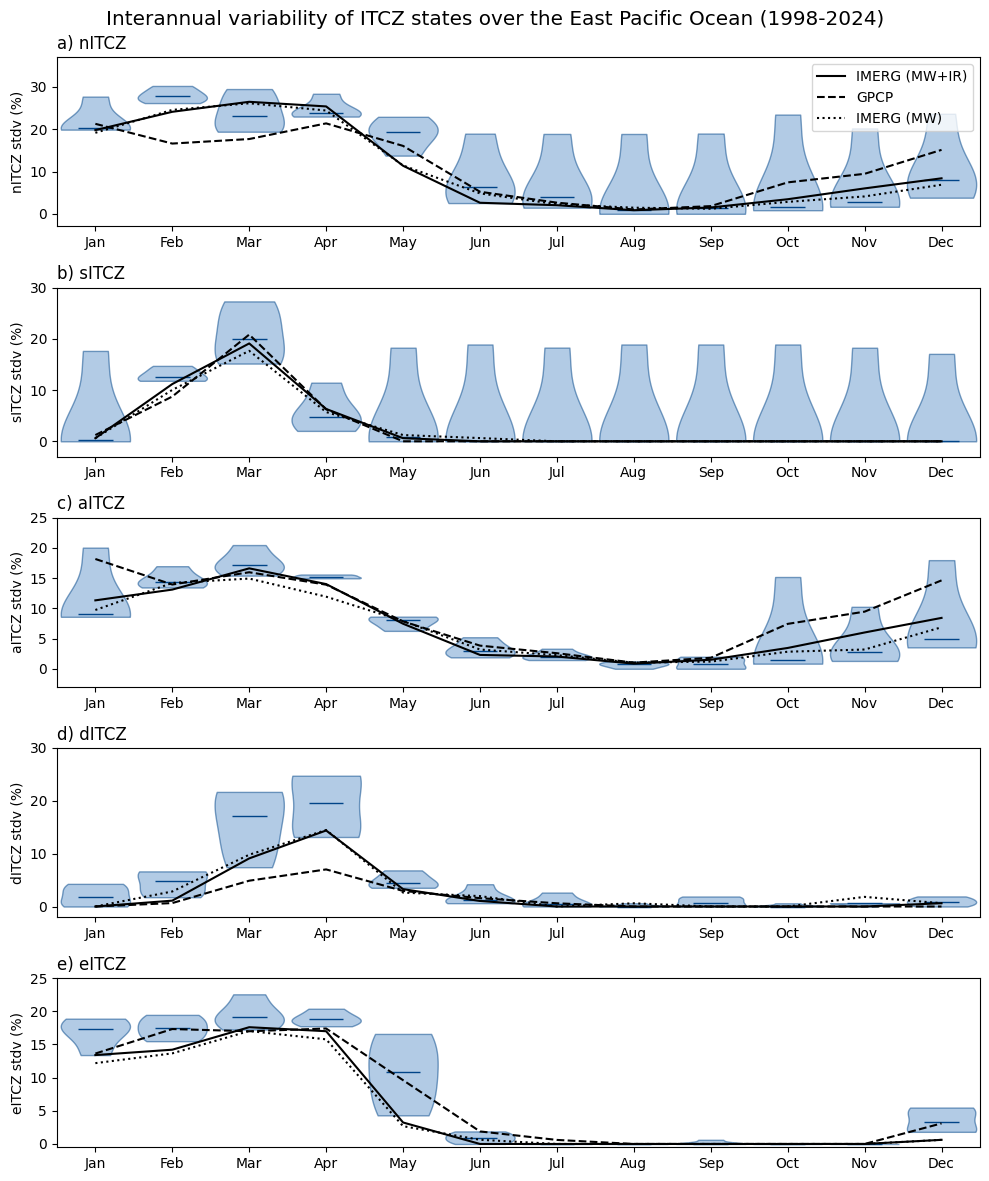

In [12]:
npan = 5

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(10, 12), tight_layout='true')
fig.suptitle(r'Interannual variability of ITCZ states over the '+region_str+' ('+yr_str+')',fontsize='x-large')
for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    #axs.set_ylim(0,105)

    if jj == 0:
        # plot violin plot
        ax1 = ax.violinplot(data_nI_interann_r[3:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,data_nI_interannr_xr.sel(dataset='IMERG'),color='k', label='IMERG (MW+IR)')
        ax3 = ax.plot(month,data_nI_interannr_xr.sel(dataset='GPCP'),color='k',linestyle='--', label='GPCP')
        ax4 = ax.plot(month,data_nI_interannr_xr.sel(dataset='IMERG_mw'),color='k',linestyle=':', label='IMERG (MW)')
        
        plt.legend(loc='upper right')
        plt.ylabel('nITCZ stdv (%)')
        plt.ylim(-3,37)
        ax.set_title('a) nITCZ', loc='left')

    if jj == 1:
        # plot violin plot
        ax1 = ax.violinplot(data_sI_interannr_xr[3:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,data_sI_interannr_xr.sel(dataset='IMERG'),color='k', label='IMERG (MW+IR)')
        ax3 = ax.plot(month,data_sI_interannr_xr.sel(dataset='GPCP'),color='k',linestyle='--')
        ax4 = ax.plot(month,data_sI_interannr_xr.sel(dataset='IMERG_mw'),color='k',linestyle=':', label='IMERG (MW)')
            
        #plt.legend(loc=4)
        plt.ylabel('sITCZ stdv (%)')
        plt.ylim(-3,30)
        ax.set_title('b) sITCZ', loc='left')

    if jj == 2:
        # plot violin plot
        ax1 = ax.violinplot(data_aI_interannr_xr[3:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,data_aI_interannr_xr.sel(dataset='IMERG'),color='k', label='IMERG (MW+IR)')
        ax3 = ax.plot(month,data_aI_interannr_xr.sel(dataset='GPCP'),color='k',linestyle='--')
        ax4 = ax.plot(month,data_aI_interannr_xr.sel(dataset='IMERG_mw'),color='k',linestyle=':', label='IMERG (MW)')
        #plt.legend(loc=4)
        plt.ylabel('aITCZ stdv (%)')
        plt.ylim(-3,25)
        ax.set_title('c) aITCZ', loc='left')
        
    if jj == 3:
        # plot violin plot
        ax1 = ax.violinplot(data_dI_interannr_xr[3:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,data_dI_interannr_xr.sel(dataset='IMERG'),color='k', label='IMERG (MW+IR)')
        ax3 = ax.plot(month,data_dI_interannr_xr.sel(dataset='GPCP'),color='k',linestyle='--')
        ax4 = ax.plot(month,data_dI_interannr_xr.sel(dataset='IMERG_mw'),color='k',linestyle=':', label='IMERG (MW)')
        #plt.legend(loc=4)
        plt.ylabel('dITCZ stdv (%)')
        plt.ylim(-2,30)
        ax.set_title('d) dITCZ', loc='left')
        
    if jj == 4:
        # plot violin plot
        ax1 = ax.violinplot(data_eI_interannr_xr[3:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,data_eI_interannr_xr.sel(dataset='IMERG'),color='k', label='IMERG (MW+IR)')
        ax3 = ax.plot(month,data_eI_interannr_xr.sel(dataset='GPCP'),color='k',linestyle='--')
        ax4 = ax.plot(month,data_eI_interannr_xr.sel(dataset='IMERG_mw'),color='k',linestyle=':', label='IMERG (MW)')
        #plt.legend(loc=4)
        plt.ylabel('eITCZ stdv (%)')
        plt.ylim(-0.5,25)
        ax.set_title('e) eITCZ', loc='left')
    
    #ax.set_title('Jan-May mean error = '+str(prc_anom_abs_median_fmt[jj])+'%', loc='right')
    plt.xlim(0.5,12.5)
    #plt.xlabel('month')
    ax.set_xticks(month,labels=mon_str)

figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
#plt.savefig(figfolder+'Interann_ITCZ_state_EastPac_reana_monthly.pdf',bbox_inches="tight",transparent=False,dpi=150)

In [13]:
colors_plt = ['k','k','k','white','#4477AA','#EE6677','#228833','#CCBB44']
line_sty_plt = ['-',':','--','-','-','-','-','-']

In [14]:
nlabel = ndatasetr+1
label_plt = np.empty((nlabel),dtype='U15')
label_plt[0] = 'IMERG (MW+IR)'
label_plt[1] = 'IMERG (MW)'
label_plt[2] = datasetr[2]
label_plt[3] = ' '
label_plt[4:] = datasetr[3:]

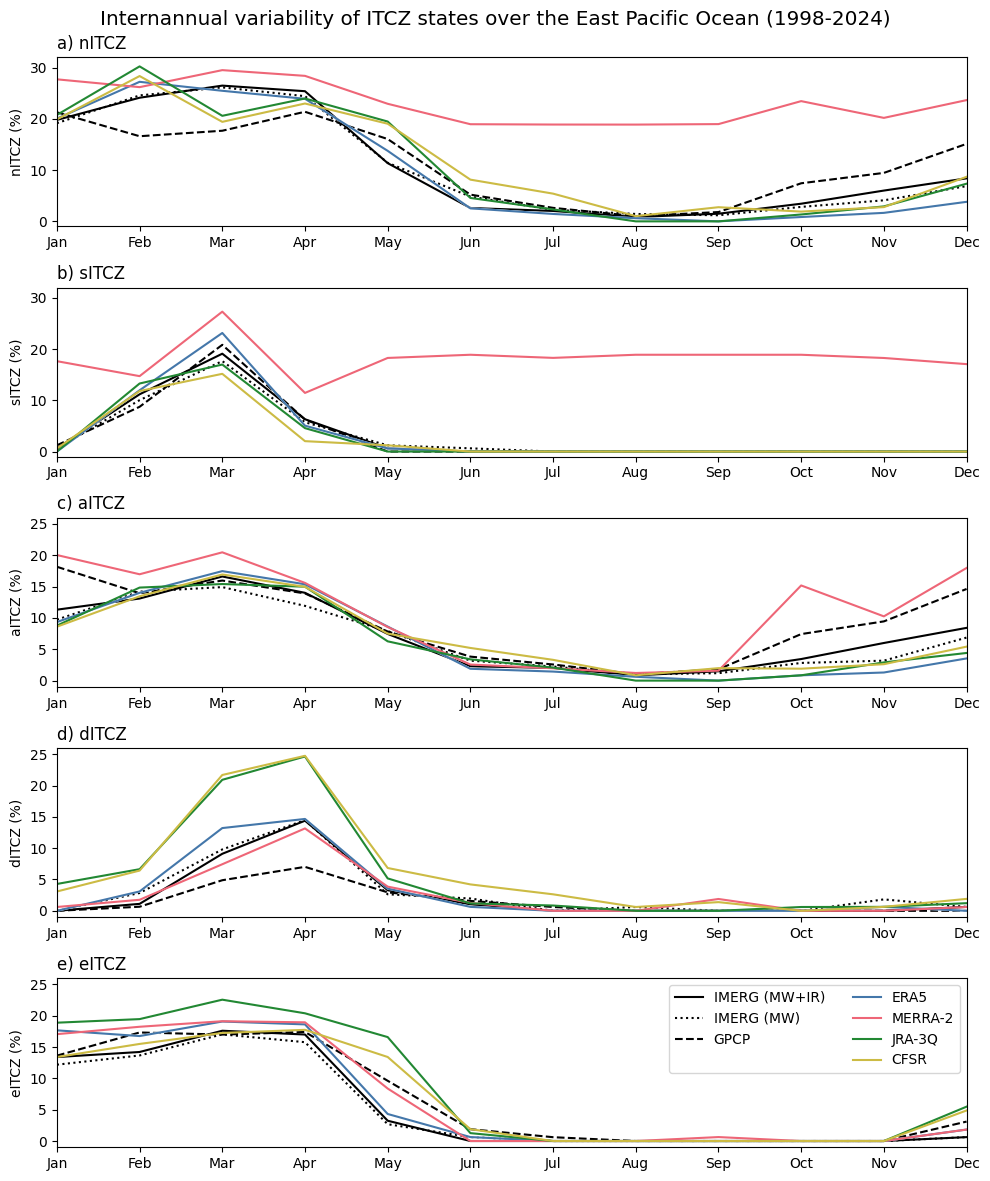

In [15]:
npan = 5

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(10, 12), tight_layout='true')
fig.suptitle(r'Internannual variability of ITCZ states over the '+region_str+' (1998-2024)',fontsize='x-large')

for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    #axs.set_ylim(0,105)
    idatar = 0
    if jj == 0:
        # plot violin plot
        for idata in range(0,nlabel):
            if idata == 4:
                idatar = idata-1
            ax1 = ax.plot(month,data_nI_interannr_xr[idatar,:],color=colors_plt[idata],linestyle=line_sty_plt[idata],label=label_plt[idata])
            idatar = idatar+1
        
        plt.ylabel('nITCZ (%)')
        plt.ylim(-1,32)
        ax.set_title('a) nITCZ', loc='left')

    if jj == 1:
        # plot violin plot
        for idata in range(0,nlabel):
            if idata == 4:
                idatar = idata-1
            ax1 = ax.plot(month,data_sI_interannr_xr[idatar,:],color=colors_plt[idata],linestyle=line_sty_plt[idata],label=label_plt[idata])
            idatar = idatar+1
        
        plt.ylabel('sITCZ (%)')
        plt.ylim(-1,32)
        ax.set_title('b) sITCZ', loc='left')

    if jj == 2:
        # plot violin plot
        for idata in range(0,nlabel):
            if idata == 4:
                idatar = idata-1
            ax1 = ax.plot(month,data_aI_interannr_xr[idatar,:],color=colors_plt[idata],linestyle=line_sty_plt[idata],label=label_plt[idata])
            idatar = idatar+1
        
        plt.ylabel('aITCZ (%)')
        plt.ylim(-1,26)
        ax.set_title('c) aITCZ', loc='left')
        
    if jj == 3:
        # plot violin plot
        for idata in range(0,nlabel):
            if idata == 4:
                idatar = idata-1
            ax1 = ax.plot(month,data_dI_interannr_xr[idatar,:],color=colors_plt[idata],linestyle=line_sty_plt[idata],label=label_plt[idata])
            idatar = idatar+1
        
        plt.ylabel('dITCZ (%)')
        plt.ylim(-1,26)
        ax.set_title('d) dITCZ', loc='left')
        
    if jj == 4:
        # plot violin plot
        for idata in range(0,nlabel):
            if idata == 4:
                idatar = idata-1
            ax1 = ax.plot(month,data_eI_interannr_xr[idatar,:],color=colors_plt[idata],linestyle=line_sty_plt[idata],label=label_plt[idata])
            idatar = idatar+1
        
        plt.legend(ncol=2,loc='upper right')
        plt.ylabel('eITCZ (%)')
        plt.ylim(-1,26)
        ax.set_title('e) eITCZ', loc='left')
    
    #ax.set_title('Jan-May mean error = '+str(prc_anom_abs_median_fmt[jj])+'%', loc='right')
    plt.xlim(1,12)
    #plt.xlabel('month')
    ax.set_xticks(month,labels=mon_str)
    
plt.savefig(figfolder+figname,bbox_inches="tight",transparent=False,dpi=150)